In [1]:
!pip install tensorflow-ranking==0.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 3.5 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 47.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Att

**Importing  libraries**

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB4
from sklearn.metrics import  classification_report
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly

In [4]:
import tensorflow_ranking as tfr

In [5]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


### Custom Hamming Loss Metric

In this code  a custom Hamming Loss metric is defined using TensorFlow and Keras. The Hamming Loss is a metric used to evaluate the accuracy of multi-label classification models. Here's an explanation of the code:

#### Custom Metric Class

- A custom metric class named `HammingLoss` is defined. This class extends the `Metric` class provided by TensorFlow/Keras.

- The `__init__` method initializes the metric. It accepts parameters such as `threshold` and `name`. The threshold defines the threshold value for binary conversion of predictions. The `hamming_loss` and `count` variables are created as TensorFlow variables to keep track of the Hamming loss and the number of samples.

#### `update_state` Method

- The `update_state` method is used to update the state of the metric. It accepts `y_true` (true labels), `y_pred` (predicted probabilities), and `sample_weight` (optional).

- The method first converts the predicted probabilities to binary labels based on the specified threshold.

- It then computes the absolute differences between the true labels and the binary predictions for each sample and class.

- The mean over classes for each sample is calculated, which represents the Hamming loss for that sample.

- The Hamming loss and the sample count are updated accordingly.

#### `result` Method

- The `result` method calculates the final Hamming loss by dividing the accumulated Hamming loss by the sample count.

#### `reset_state` Method

- The `reset_state` method is used to reset the Hamming loss and sample count at the end of each epoch. This is important to ensure that the metric calculations are isolated for each epoch.

This custom Hamming Loss metric can be used during the training of multi-label classification models to monitor and evaluate the model's performance with regard to label prediction accuracy.




In [6]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class HammingLoss(Metric):
    def __init__(self, threshold=0.5, name="hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name=name, **kwargs)
        self.threshold = tf.Variable(threshold, trainable=False, dtype=tf.float32)
        self.hamming_loss = self.add_weight(name="hl", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tmp = tf.math.abs(y_true - y_pred_binary)
        hl = tf.math.reduce_mean(tmp, axis=-1)
        self.hamming_loss.assign_add(tf.math.reduce_sum(hl))
        self.count.assign_add(tf.cast(tf.size(y_true) / tf.shape(y_true)[-1], tf.float32))
    def result(self):
        return self.hamming_loss / self.count
    def reset_state(self):
        self.hamming_loss.assign(0.)
        self.count.assign(0.)

### Data Loading and Filtering

This section covers the process of loading data from CSV files and applying filtering to include only specific rows based on the value of the `Disease_Risk` column.

- The data is loaded from the following CSV files:
  - Training data: `train_file.csv`
  - Validation data: `val_file.csv`
  - Test data: `test_file.csv`

- To ensure that the analysis focuses on samples relevant to disease risk, a filter is applied to select rows where the `Disease_Risk` column is equal to 1. This step helps exclude unrelated data.

- Additionally, the disease labels are extracted into the `labels` variable for further reference.

- Finally, information is provided on the sizes of the resulting datasets, including the number of samples in the training, validation, and test sets.

This data preparation process ensures that subsequent analysis or model training is based on the most relevant samples with disease risk.


In [8]:
train_data = pd.read_csv('/kaggle/input/my-data/train_file.csv')
val_data = pd.read_csv('/kaggle/input/my-data/val_file.csv')
test_data = pd.read_csv('/kaggle/input/my-data/test_file.csv')
train_data = train_data[train_data['Disease_Risk'] == 1]
val_data = val_data[val_data['Disease_Risk'] == 1]
test_data = test_data[test_data['Disease_Risk'] == 1]
labels = train_data.columns[2:-1]
len_train_data = len(train_data)
len_val_data = len(val_data)
len_test_data = len(test_data)
filtered_size = len_train_data + len_val_data + len_test_data

len(train_data), len(val_data), len(test_data),filtered_size

(7502, 934, 953, 9389)

### Custom Image Augmentation Layer

In the following code  a custom image augmentation layer is defined using TensorFlow and Keras. This custom layer is designed to apply various image augmentation operations for data preprocessing and augmentation in deep learning models. Here's an explanation of the code:

#### Custom Image Augmentation Class

- The code defines a class called `CustomImageAugmentation` that inherits from `tf.keras.layers.Layer`. This class serves as the foundation for applying image augmentation techniques to input images.

- The class constructor (`__init__`) is responsible for initializing the image augmentation layer. It accepts a set of parameters that allow customization of which augmentation operations are applied. These operations include horizontal flipping, rotation, brightness adjustment, contrast adjustment, saturation adjustment, hue adjustment, scaling, cropping, grid distortion, compression, Gaussian noise, Gaussian blur, downscaling, gamma correction, and elastic transformation.

- The `call` method within this class is used to apply the specified augmentation operations to input images. It includes a parameter named `apply` that controls whether the augmentations should be applied or not.

- The augmentation operations are diverse and encompass random horizontal flipping, random rotation, random brightness, contrast, saturation, and hue adjustments, scaling, and more. The application of each operation is controlled by the corresponding class attribute, such as `self.flip` and `self.rotate`.

- If the `apply` parameter is set to `True`, the augmentation operations are applied to the input images; otherwise, the original images are returned.

- The `img_aug` variable represents an instance of the `CustomImageAugmentation` class, which can be used for data augmentation within image-based deep learning models.

This custom image augmentation layer offers flexibility in specifying and applying image transformations, enhancing model generalization and performance when working with image datasets.


In [12]:
import tensorflow as tf
class CustomImageAugmentation(tf.keras.layers.Layer):
    def __init__(self, flip=True, rotate=True, brightness=True,
                 contrast=True, saturation=True, hue=True, scale=False,
                 crop=False, grid_distortion=False, compression=False,
                 gaussian_noise=False, gaussian_blur=False,
                 downscaling=False, gamma=False, elastic_transform=False, **kwargs):
        super(CustomImageAugmentation, self).__init__(**kwargs)
        self.flip = flip
        self.rotate = rotate
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.scale = scale
        self.crop = crop
        self.grid_distortion = grid_distortion
        self.compression = compression
        self.gaussian_noise = gaussian_noise
        self.gaussian_blur = gaussian_blur
        self.downscaling = downscaling
        self.gamma = gamma
        self.elastic_transform = elastic_transform

    def call(self, inputs, apply=True):
        if apply:
            augmented = tf.image.random_flip_left_right(inputs) if self.flip else inputs
            augmented = tf.image.rot90(augmented, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) if self.rotate else augmented
            augmented = tf.image.random_brightness(augmented, max_delta=0.2) if self.brightness else augmented
            augmented = tf.image.random_contrast(augmented, lower=0.5, upper=1.5) if self.contrast else augmented
            augmented = tf.image.random_saturation(augmented, lower=0.5, upper=1.5) if self.saturation else augmented
            augmented = tf.image.random_hue(augmented, max_delta=0.2) if self.hue else augmented
            return augmented
        else:
            return inputs
img_aug = CustomImageAugmentation()

### Custom Image Data Generator for Augmentation

In this code a custom image data generator is defined using TensorFlow and Keras. This data generator is designed to apply various image augmentation operations to preprocess and augment data in deep learning models. Here's an explanation of the code:

#### Custom Image Data Generator Class

- A custom image data generator class is created using TensorFlow and Keras.

- The data generator is configured with various augmentation operations that can be applied during data preprocessing.

- The `preprocessing_function` parameter is defined as a lambda function that utilizes the `img_aug` function with the `apply=True` flag to apply augmentation operations.

- The defined data generator can be used to preprocess and augment images during the training of deep learning models, enhancing the model's ability to learn from diverse and augmented data.




In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=lambda x: img_aug(x, apply=True)
)

### Data Generator for Training

In this code a data generator for training deep learning models is defined using TensorFlow and Keras. The data generator is configured to preprocess and augment the training data. Here's an explanation of the code:

#### Data Generator Configuration

- The data generator is configured with the specified `target_size` of (380, 380), which defines the desired size of input images.

- The `batch_size` is set to 32, determining the number of samples to process in each batch during training.

#### Data Flow Configuration

- The `train_generator` is created using the `datagen.flow_from_dataframe` method.

- It is associated with the training data stored in the `train_data` DataFrame.

- The `x_col` parameter specifies the column name in the DataFrame where image file paths are stored.

- The `y_col` parameter is set to the list of column names representing the labels in the DataFrame. These columns are obtained from `train_data.columns[2:-1].tolist()`.

- The `class_mode` is set to 'raw', indicating that the generator should return raw arrays as the target values.

- Images are processed in batches of size `batch_size`.

- The `target_size` parameter is set to the specified dimensions of (380, 380) for image resizing.

- Data shuffling is enabled with the `shuffle` parameter set to `True`.

This data generator is essential for efficiently feeding training data to deep learning models, enabling data augmentation and resizing to match model input requirements.


In [14]:
target_size=(380, 380)
batch_size=32
train_gen = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='IMG_DIR',
    y_col=train_data.columns[2:-1].tolist(),
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True
)

Found 7502 validated image filenames.


In [16]:
val_gen = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='IMG_DIR',
    y_col=val_data.columns[2:-1].tolist(),
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)

Found 934 validated image filenames.


In [17]:
test_gen = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='IMG_DIR',
    y_col=test_data.columns[2:-1].tolist(),
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  
)

Found 953 validated image filenames.


In [19]:
for batch_images, batch_labels in train_gen:
    print("Batch images shape:", batch_images.shape)
    print("Batch labels shape:", batch_labels.shape)
    break

Batch images shape: (32, 380, 380, 3)
Batch labels shape: (32, 28)


### Custom Callback for Monitoring and Adjusting Model Training

This code defines a custom callback class, `LRA`, used during the training of a Keras model. The callback is responsible for monitoring the training process, adjusting learning rates, and making decisions based on certain criteria. It follows the ModelCheckpoint format for monitoring and adjusting the model.

#### Callback Initialization

- The `LRA` class is initialized with various parameters:
  - `model`: The Keras model to be trained.
  - `base_model`: The base model if using transfer learning (set to `None` if not).
  - `patience`: The number of epochs to wait for improvement before adjusting the learning rate.
  - `stop_patience`: The number of epochs to wait before stopping training if no improvement occurs.
  - `threshold`: A threshold to determine whether to monitor validation accuracy or loss.
  - `factor`: The factor to reduce the learning rate by when adjustments are needed.
  - `dwell`: A boolean indicating whether to set model weights back to the best weights of the previous epoch.
  - `batches`: The total number of batches for training.
  - `initial_epoch`: The initial epoch number.
  - `epochs`: The total number of epochs for training.
  - `ask_epoch`: The epoch to ask the user for further instructions or intervention during training.
  - `csv_path`: The path for saving training progress data to a CSV file (optional).

#### Callback Initialization Message

- The code generates a message indicating the initialization status of the callback. It mentions whether the base model is trainable or not.

#### Training Progress Display

- During training, the code displays training progress in a tabular format, including details such as epoch, loss, accuracy, AUC, precision, recall, F1-score, hamming loss, Map, and more. The information is color-coded for better visibility.

#### Learning Rate Adjustment

- The callback monitors different metrics (validation accuracy, validation F1-score, or validation loss) based on the defined threshold and makes decisions accordingly.
- If validation accuracy is below the threshold, it monitors validation accuracy. If validation F1-score is below 0.8, it monitors validation F1-score. Otherwise, it monitors validation loss.
- The callback keeps track of the highest validation accuracy, lowest validation loss, and highest validation F1-score, making adjustments and storing the best weights as necessary.
- It reduces the learning rate by a factor when required and resets model weights to the best weights if `dwell` is set to `True`.
- The callback also handles cases where training may be halted or further instructions are needed based on user input.
- Progress data is recorded in the `data_dict` for later analysis.

#### Early Stopping

- The callback implements early stopping logic by monitoring improvement in training metrics and halting training if no progress is made within the defined `stop_patience`.

#### Training Duration

- The total training duration is calculated and displayed at the end of training.

This `LRA` callback offers a comprehensive set of features to monitor and control the training process of a Keras model, making it a valuable tool for managing and optimizing model training.


In [20]:

class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch, csv_path=None):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience 
        self.stop_patience=stop_patience 
        self.threshold=threshold 
        self.factor=factor 
        self.dwell=dwell
        self.batches=batches 
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch 
        self.csv_path=csv_path
        self.count=0 
        self.stop_count=0   
        self.highest_f1_score=0
        self.best_epoch=1          
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr))        
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf 
        self.best_weights=self.model.get_weights() 
        self.initial_weights=self.model.get_weights()   
        self.data_dict={}
        for key in ['Epoch', 'Loss', 'Accuracy','Auc','Auc_roc','Auc_pr','Precision','Recall','F1_score','Hamming_loss','Map','V_loss','V_acc','V_auc','Val_auc_roc','Val_auc_pr','Val_precision','Val_recall','Val_f1_score' ,'Val_hamming_loss','Val_map','LR', 'Next LR', 'Monitor','% Improv', 'Duration']:
            self.data_dict[key]=[]
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting training with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg = '{0:^12s}{1:^12s}{2:^12s}{3:^12s}{4:^12s}{5:^12s}{6:^14s}{7:^12s}{8:^12s}{9:^14s}{10:^12s}{11:^14s}{12:^18s}{13:^12s}{14:^12s}{15:^14s}{16:^18s}{17:^12s}{18:^15s}{19:^12s}{20:^14s}{21:^15s}{22:^18s}{23:^14s}{24:^18s}{25:^12s}'.format(
                'Epoch', 'Loss', 'Accuracy','Auc','Auc_roc','Auc_pr', 'Precision', 'Recall', 'F1_score', 'Hamming_loss','Map',
                    'V_loss', 'V_acc','V_auc','Val_auc_roc','Val_auc_pr', 'Val_precision', 'Val_recall', 'Val_f1_score', 'Val_hamming_loss','Val_map',
                'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
                )
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        if self.csv_path !=None:
            df=pd.DataFrame.from_dict(self.data_dict)
            now = datetime.now() 
            year = str(now.year)
            month=str(now.month)
            day=str(now.day)
            hour=str(now.hour)
            minute=str(now.minute)
            sec=str(now.second)
            label = month + '-'+ day + '-' + year + '-' + hour + '-' + minute + '-' + sec +'.csv'
            csv_path=self.csv_path + '-'+ label
            df.to_csv(csv_path, index=False)        

        self.model.set_weights(self.best_weights) 
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        precision = logs.get('precision')
        auc=logs.get('auc')
        recall = logs.get('recall')
        f1_score = logs.get('f1_score')
        hamming_loss = logs.get('hamming_loss')
        Map=logs.get('map')
        auc_roc=logs.get('auc_roc')
        auc_pr=logs.get('auc_pr')
        msg = '{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f} auc: {4:8.5f}   precision: {5:.3f}  recall: {6:.3f}  f1_score: {7:.3f}  hamming_loss: {8:.5f} loss:{9:.5f}Map:{10:.5f} auc_roc: {11:8.5f} auc_pr: {12:8.5f}'.format(
            ' ', str(batch), str(self.batches), acc, auc, precision, recall, f1_score, hamming_loss,loss,Map,auc_roc,auc_pr)
        print(msg, '\r', end='')     
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr=lr
        v_loss=logs.get('val_loss')  
        acc=logs.get('accuracy') 
        loss=logs.get('loss')
        auc=logs.get('auc')
        v_auc=logs.get('val_auc')
        Map=logs.get('map')
        val_map=logs.get('val_map')
        v_acc = logs.get('val_accuracy')
        val_precision = logs.get('val_precision')
        val_recall = logs.get('val_recall')
        val_f1_score = logs.get('val_f1_score')
        val_hamming_loss = logs.get('val_hamming_loss')
        precision = logs.get('precision')
        recall = logs.get('recall')
        f1_score = logs.get('f1_score')
        hamming_loss = logs.get('hamming_loss')
        auc_roc=logs.get('auc_roc')
        val_auc_roc=logs.get('val_auc_roc')
        auc_pr=logs.get('auc_pr')
        val_auc_pr=logs.get('val_auc_pr')
        if v_acc < self.threshold: 
            monitor='val_accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (v_acc-self.highest_tracc )*100/self.highest_tracc
            if v_acc>self.highest_tracc: 
                self.highest_tracc=v_acc 
                self.best_weights=self.model.get_weights()
                self.count=0 
                self.stop_count=0 
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                if val_f1_score>self.highest_f1_score :
                    self.highest_f1_score = val_f1_score
                color= (0,255,0)
                self.best_epoch=epoch + 1              
            else: 
                if self.count>=self.patience -1: 
                    color=(245, 170, 66)
                    lr= lr* self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                    self.count=0 
                    self.stop_count=self.stop_count + 1 
                    self.count=0 
                    if self.dwell:
                        self.model.set_weights(self.best_weights)                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss    
                        if val_f1_score>self.highest_f1_score :
                            self.highest_f1_score = val_f1_score
                else:
                    self.count=self.count +1 
        
        elif val_f1_score < 0.8: 
            monitor='val_f1_score'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (val_f1_score-self.highest_f1_score )*100/self.highest_f1_score
            if val_f1_score>self.highest_f1_score:
                self.highest_f1_score=val_f1_score 
                self.best_weights=self.model.get_weights() 
                self.count=0 
                self.stop_count=0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                if v_acc>self.highest_tracc:
                    self.highest_tracc= v_acc
                color= (0,255,0)
                self.best_epoch=epoch + 1            
            else: 
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    lr= lr* self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                    self.count=0 
                    self.stop_count=self.stop_count + 1 
                    self.count=0 
                    if self.dwell:
                        self.model.set_weights(self.best_weights)                    
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss  
                        if v_acc>self.highest_tracc:
                            self.highest_tracc= v_acc
                else:
                    self.count=self.count +1       
        else: 
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: 
                self.lowest_vloss=v_loss                
                self.best_weights=self.model.get_weights() 
                self.count=0 
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 
            else: 
                if self.count>=self.patience-1: 
                    color=(245, 170, 66)
                    lr=lr * self.factor                   
                    self.stop_count=self.stop_count + 1 
                    self.count=0 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                    if self.dwell:
                        self.model.set_weights(self.best_weights) 
                else: 
                    self.count =self.count +1                   
                if v_acc>self.highest_tracc:
                    self.highest_tracc= v_acc
                if val_f1_score>self.highest_f1_score :
                    self.highest_f1_score = val_f1_score

        msg=f'{str(epoch+1):^3s}/{str(self.epochs):^4s}{loss:^12.3f}{acc*100:^12.3f}{auc*100:^12.3f}{auc_roc*100:^12.3f}{auc_pr*100:^14.3f}{precision:^12.3f}{recall:^12.3f}{f1_score:^14.3f}{hamming_loss:^12.3f}{Map:^14.3f}{v_loss:^18.3f}{v_acc*100:^12.3f}{v_auc*100:^12.3f}{val_auc_roc*100:^14.3f}{val_auc_pr*100:^18.3f}{val_precision:^12.3f}{val_recall:^12.3f}{val_f1_score:^18.3f}{val_hamming_loss:^12.3f}{val_map:^14.3f}{current_lr:^15.8f}{lr:^18.8f}{monitor:^14s}{pimprov:^18.3f}{duration:^12.3f}'
        
        print_in_color (msg,(0,255,255), (55,65,80))
        key_list=['Epoch', 'Loss', 'Accuracy','Auc','Auc_roc','Auc_pr','Precision','Recall','F1_score','Hamming_loss','Map','V_loss','V_acc','V_auc','Val_auc_roc','Val_auc_pr','Val_precision','Val_recall','Val_f1_score' ,'Val_hamming_loss','Val_map','LR', 'Next LR', 'Monitor','% Improv', 'Duration']
        val_list =[epoch + 1, loss, acc,auc,auc_roc,auc_pr,precision,recall,f1_score,hamming_loss,Map, v_loss, v_acc,v_auc,val_auc_roc,val_auc_pr,val_precision,val_recall,val_f1_score,val_hamming_loss,val_map, current_lr, lr, monitor, pimprov, duration]
        for key, value in zip(key_list, val_list):
           self.data_dict[key].append(value)
        
        if self.stop_count> self.stop_patience - 1: 
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True 
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt training ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')                    
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True 
                    elif ans == 'T' or ans=='t':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='Enter an integer for the number of epochs to run then be asked again'
                        print_in_color(msg, (0,2555,255), (55,65,80))
                        ans=input()
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch) 
                        print_in_color(msg, (0, 255,255), (55,65,80))    
                        print_in_color(msg, (244,252,3), (55,65,80)) 
                        msg = '{0:^12s}{1:^12s}{2:^12s}{3:^12s}{4:^12s}{5:^12s}{6:^14s}{7:^12s}{8:^12s}{9:^14s}{10:^12s}{11:^14s}{12:^18s}{13:^12s}{14:^12s}{15:^14s}{16:^18s}{17:^12s}{18:^15s}{19:^12s}{20:^14s}{21:^15s}{22:^18s}{23:^14s}{24:^18s}{25:^12s}'.format(
                            'Epoch', 'Loss', 'Accuracy','Auc','Auc_roc','Auc_pr', 'Precision', 'Recall', 'F1_score', 'Hamming_loss','Map',
                            'V_loss', 'V_acc','V_auc','Val_auc_roc','Val_auc_pr', 'Val_precision', 'Val_recall', 'Val_f1_score', 'Val_hamming_loss','Val_map',
                            'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
                                )                        
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg = '{0:^12s}{1:^12s}{2:^12s}{3:^12s}{4:^12s}{5:^12s}{6:^14s}{7:^12s}{8:^12s}{9:^14s}{10:^12s}{11:^14s}{12:^18s}{13:^12s}{14:^12s}{15:^14s}{16:^18s}{17:^12s}{18:^15s}{19:^12s}{20:^14s}{21:^15s}{22:^18s}{23:^14s}{24:^18s}{25:^12s}'.format(
                                'Epoch', 'Loss', 'Accuracy','Auc','Auc_roc','Auc_pr', 'Precision', 'Recall', 'F1_score', 'Hamming_loss','Map',
                                'V_loss', 'V_acc','V_auc','Val_auc_roc','Val_auc_pr', 'Val_precision', 'Val_recall', 'Val_f1_score', 'Val_hamming_loss','val_map',
                            'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
                            )
                        print_in_color(msg, (244,252,3), (55,65,80)) 

### Training History Plot

This code  is used to create a comprehensive plot of training history for a machine learning model. It visualizes various metrics over epochs to help analyze the model's performance during training.

#### Function Description

The `tr_plot` function takes three main arguments:
- `tr_data`: The training data, typically containing the model's training history.
- `start_epoch`: The epoch number at which the training started.
- `history`: The history object that contains training metrics.

The code starts by setting up the plotting environment using the `seaborn` library with a white background style.

Next, it extracts various training metrics and validation metrics from the `history` object, including accuracy, loss, F1 score, precision, recall, hamming loss, AUC ROC, and AUC PR.

The code calculates several indices, such as the epoch with the lowest validation loss, the highest validation accuracy, the highest F1 score, and more. These indices help identify the best-performing epochs during training.

The code then creates a multi-plot figure with four rows and two columns. Each row represents a different metric, and the columns show training and validation values for that metric.

For each metric, the code plots the training and validation values over epochs. It also adds vertical lines to indicate the start of fine-tuning (usually after 10 initial epochs) and a marker for the best-performing epoch.

The following metrics are visualized:
1. Training and Validation Loss
2. Training and Validation Accuracy
3. Training and Validation F1 Score
4. Training and Validation Hamming Loss
5. Training and Validation Precision
6. Training and Validation Recall
7. Training and Validation AUC ROC
8. Training and Validation AUC PR

Finally, the code ensures the plot is well-structured and displays it.

This plot is a valuable tool for monitoring and analyzing the training progress of a machine learning model. It helps identify the best epochs and gain insights into the model's performance.




In [21]:
sns.set(style='white')
def tr_plot(tr_data, start_epoch,history):
    initial_epochs=10
    tacc=history.history['accuracy']
    tloss=history.history['loss']
    vacc=history.history['val_accuracy']
    vloss=history.history['val_loss']
    tf1_scores = history.history['f1_score'] 
    vf1_scores = history.history['val_f1_score'] 
    tprecisions = history.history['precision']
    vprecisions =history.history['val_precision'] 
    trecalls = history.history['recall']
    vrecalls = history.history['val_recall'] 
    thamming_losses = history.history['hamming_loss']
    vhamming_losses = history.history['val_hamming_loss']
    tauc_roc =history.history['auc_roc']
    vauc_roc = history.history['val_auc_roc']
    tauc_pr = history.history['auc_pr']
    vauc_pr = history.history['val_auc_pr']
    tacc +=tr_data.history['accuracy']
    tloss +=tr_data.history['loss']
    vacc +=tr_data.history['val_accuracy']
    vloss +=tr_data.history['val_loss']
    tf1_scores += tr_data.history['f1_score'] 
    vf1_scores += tr_data.history['val_f1_score'] 
    tprecisions += tr_data.history['precision']
    vprecisions += tr_data.history['val_precision'] 
    trecalls += tr_data.history['recall']
    vrecalls += tr_data.history['val_recall'] 
    thamming_losses += tr_data.history['hamming_loss']
    vhamming_losses += tr_data.history['val_hamming_loss']
    tauc_roc += tr_data.history['auc_roc']
    vauc_roc += tr_data.history['val_auc_roc']
    tauc_pr += tr_data.history['auc_pr']
    vauc_pr += tr_data.history['val_auc_pr']
    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    
    index_hloss = np.argmin(vhamming_losses)
    val_hlowest = vhamming_losses[index_hloss]
    
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    index_vf1 = np.argmax(vf1_scores)
    vf1_highest = vf1_scores[index_vf1]
    
    index_vprecisions = np.argmax(vprecisions)
    vprecisions_highest = vprecisions[index_vprecisions]
    
    index_vrecalls = np.argmax(vrecalls)
    vrecalls_highest = vrecalls[index_vrecalls]
    
    index_vauc_roc = np.argmax(vauc_roc)
    vauc_roc_highest = vauc_roc[index_vauc_roc] 
    
    index_vauc_pr = np.argmax(vauc_pr)
    vauc_pr_highest = vauc_pr[index_vauc_pr]
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    vf1_label = 'best epoch= '+ str(index_vf1 + 1 + start_epoch)
    vhloss_label = 'best epoch= '+ str(index_hloss + 1 + start_epoch)
    vprecision_label = 'best epoch= '+ str(index_vprecisions + 1 + start_epoch)
    vrecall_label = 'best epoch= '+ str(index_vrecalls + 1 + start_epoch)
    vauc_roc_label = 'best epoch= '+ str(index_vauc_roc + 1 + start_epoch)
    vauc_pr_label = 'best epoch= '+ str(index_vauc_pr + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

    axes[0, 0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0, 0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0, 0].plot([initial_epochs-1,initial_epochs-1],
        axes[0, 0].set_ylim(), label='Start Fine Tuning')
    axes[0, 0].scatter(index_loss + start_epoch + 1, val_lowest, s=150, c='blue', label=sc_label)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[1, 0].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1, 0].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1, 0].plot([initial_epochs-1,initial_epochs-1],
        axes[1, 0].set_ylim(), label='Start Fine Tuning')
    axes[1, 0].scatter(index_acc + start_epoch + 1, acc_highest, s=150, c='blue', label=vc_label)
    axes[1, 0].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()

    axes[2, 0].plot(Epochs, tf1_scores, 'r', label='Training F1 Score')
    axes[2, 0].plot(Epochs, vf1_scores, 'g', label='Validation F1 Score')
    axes[2, 0].plot([initial_epochs-1,initial_epochs-1],
        axes[2, 0].set_ylim(), label='Start Fine Tuning')
    axes[2, 0].scatter(index_vf1 + start_epoch + 1, vf1_highest, s=150, c='blue', label=vf1_label)
    axes[2, 0].set_title('Training and Validation F1 Score', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    axes[2, 0].set_xlabel('Epochs')
    axes[2, 0].set_ylabel('F1 Score')
    axes[2, 0].legend()

    axes[3, 0].plot(Epochs, thamming_losses, 'r', label='Training Hamming Loss')
    axes[3, 0].plot(Epochs, vhamming_losses, 'g', label='Validation Hamming Loss')
    axes[3, 0].plot([initial_epochs-1,initial_epochs-1],
          axes[3, 0].set_ylim(), label='Start Fine Tuning')
    axes[3, 0].scatter(index_hloss + start_epoch + 1, val_hlowest, s=150, c='blue', label=vhloss_label)
    axes[3, 0].set_title('Training and Validation Hamming Loss', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    axes[3, 0].set_xlabel('Epochs')
    axes[3, 0].set_ylabel('Hamming Loss')
    axes[3, 0].legend()

    axes[0, 1].plot(Epochs, tprecisions, 'r', label='Training Precision')
    axes[0, 1].plot(Epochs, vprecisions, 'g', label='Validation Precision')
    axes[0, 1].plot([initial_epochs-1,initial_epochs-1],
          axes[0, 1].set_ylim(), label='Start Fine Tuning')
    axes[0, 1].scatter(index_vprecisions + start_epoch + 1, vprecisions_highest, s=150, c='blue', label=vprecision_label)
    axes[0, 1].set_title('Training and Validation Precision', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend()

    axes[1, 1].plot(Epochs, trecalls, 'r', label='Training Recall')
    axes[1, 1].plot(Epochs, vrecalls, 'g', label='Validation Recall')
    axes[1, 1].plot([initial_epochs-1,initial_epochs-1],
          axes[1, 1].set_ylim(), label='Start Fine Tuning')
    axes[1, 1].scatter(index_vrecalls + start_epoch + 1, vrecalls_highest, s=150, c='blue', label=vrecall_label )
    axes[1, 1].set_title('Training and Validation Recall', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()

    axes[2, 1].plot(Epochs, tauc_roc, 'r', label='Training AUC ROC')
    axes[2, 1].plot(Epochs, vauc_roc, 'g', label='Validation AUC ROC')
    axes[2, 1].plot([initial_epochs-1,initial_epochs-1],
          axes[2, 1].set_ylim(), label='Start Fine Tuning')
    axes[2, 1].scatter(index_vauc_roc + start_epoch + 1, vauc_roc_highest, s=150, c='blue', label=vauc_roc_label)
    axes[2, 1].set_title('Training and Validation AUC ROC', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    axes[2, 1].set_xlabel('Epochs')
    axes[2, 1].set_ylabel('AUC ROC')
    axes[2, 1].legend()

    axes[3, 1].plot(Epochs, tauc_pr, 'r', label='Training AUC PR')
    axes[3, 1].plot(Epochs, vauc_pr, 'g', label='Validation AUC PR')
    axes[3, 1].plot([initial_epochs-1,initial_epochs-1],
          axes[3, 1].set_ylim(), label='Start Fine Tuning')
    axes[3, 1].scatter(index_vauc_pr + start_epoch + 1, vauc_pr_highest, s=150, c='blue', label=vauc_pr_label)
    axes[3, 1].set_title('Training and Validation AUC PR', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    axes[3, 1].set_xlabel('Epochs')
    axes[3, 1].set_ylabel('AUC PR')
    axes[3, 1].legend()

    plt.tight_layout()
    plt.show()


### Printing Information and Evaluation Metrics

In this code  a Python function named `print_info` is defined for analyzing the performance of a machine learning model and printing various information and evaluation metrics.

#### Function Description

The `print_info` function takes the following parameters:

- `test_gen`: Test data generator, typically containing test data.
- `preds`: Model predictions for the test data.
- `print_code`: An integer parameter that controls the amount of information to be printed.

The code performs the following tasks:

1. Extracts class information from the test data and creates a dictionary for mapping class indices to class names.
2. Calculates the accuracy of the model by comparing the predictions to the true labels and counting errors.
3. If `print_code` is greater than zero and there are errors in the predictions, the code prints error details, including filenames, predicted classes, true classes, and probabilities.
4. Creates a bar chart to visualize the distribution of errors by class.
5. Evaluates the model's performance using various metrics, including multilabel confusion matrices, classification reports, and F1 scores.
6. Visualizes the F1 scores for each class in a horizontal bar chart.


In [22]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
def print_info( test_gen, preds, print_code ):
    class_columns = test_data.columns[2:-1].tolist()
    class_dict = {class_name: idx for idx, class_name in enumerate(class_columns)}
    labels = test_gen.labels

    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             
    classes=list(new_dict.values())  
    threshold = 0.5
    y_pred = (preds > threshold).astype(int)
    errors=0
    for i in range(len(preds)):
        true_indices = np.where(labels[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        incorrect_indices = np.setdiff1d(true_indices, pred_indices)

        if len(incorrect_indices) > 0:
            error_list.append(file_names[i])
            true_class.append([new_dict[index] for index in true_indices])
            pred_class.append([new_dict[index] for index in pred_indices])
            prob_list.append([preds[i, index] for index in pred_indices])
            error_indices.extend(true_indices)
            errors += 1 
    tests=len(preds)

    acc= (1-errors/tests) *100
    msg= f'There were {errors} errors in {tests} test cases Model accuracy= {acc: 6.2f} %'
    print_in_color(msg,(0,255,255),(55,65,80))

    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                prob_str = ', '.join([f'{prob:.4f}' for prob in prob_list[i]])
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4}'.format(fname, ', '.join(pred_class[i]), ', '.join(true_class[i]), ' ', prob_str)
                print_in_color(msg, (255,255,255), (55,65,60))
          
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)   
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set', fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes) <= 30:
        mcm = multilabel_confusion_matrix(y_true, y_pred)

        num_labels = class_columns 
        num_columns = 4
        num_rows = (len(num_labels) + num_columns - 1) // num_columns  
        fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 3*num_rows))  

        for label_index in range(len(num_labels)):
            row = label_index // num_columns
            col = label_index % num_columns
            label_preds = preds[:, label_index]  
    
            ax = axes[row, col]
            sns.heatmap(mcm[label_index], annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax, square=True, linewidths=0.5, linecolor='lightgray')
            ax.set_title(f"Confusion Matrix for Class: {num_labels[label_index]}", fontsize=14, fontweight='bold', pad=10)  
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

            ax.title.set_bbox(dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.tight_layout()
    plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4,zero_division=1)
    print("Classification Report:\n----------------------\n", clr)

    f1_scores = [f1_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]


    classes = class_columns


    plt.figure(figsize=(10, 10))
    plt.rcParams['ytick.labelsize'] = 12  


    bar_positions = range(len(classes))
    plt.barh(bar_positions, f1_scores, color='blue')
    plt.xlabel("F1 Score")
    plt.ylabel("Class")
    plt.title("F1 Scores for Each Class", fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
    plt.yticks(bar_positions, classes)  
    plt.tight_layout()
    plt.show()
    return acc/100

### Model and Class Dictionary Saver

In this code  a Python function named `saver` is defined to save a machine learning model and generate a class dictionary as a CSV file.

#### Function Description

The `saver` function takes several parameters:

- `save_path`: The directory path where the model and class dictionary will be saved.
- `model`: The machine learning model to be saved.
- `model_name`: The name of the model.
- `subject`: A subject or identifier associated with the model.
- `accuracy`: The model's accuracy.
- `img_size`: A tuple representing the image dimensions (height and width).
- `scalar`: A scale factor.
- `offset`: An offset value.
- `generator`: A data generator or related object.

The code performs the following tasks:

1. Saves the machine learning model with a filename based on the `model_name`, `subject`, and `accuracy`.
2. Creates a class dictionary based on class columns extracted from the training data.
3. Generates a class DataFrame containing class index, class name, image dimensions, scale factor, and offset.
4. Saves the class dictionary as a CSV file.
5. Returns the file paths for both the saved model and the class dictionary.



In [23]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar,offset ,generator):    
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    class_columns = train_data.columns[2:-1].tolist()
    class_dict = {class_name: idx for idx, class_name in enumerate(class_columns)}


    height=[]
    width=[]
    scale=[]
    off=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar) 
        off.append(offset)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    Off_series=pd.Series(off, name='Offset')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series, Off_series],axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

In [24]:
img_shape=(380,380,3)

In [25]:
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))
train_steps

235

In [26]:
working_dir = '/kaggle/working/'

### Model Definition with TensorFlow and Regularization

In this code a deep learning model is defined using TensorFlow with regularization techniques. The model is created with the `EfficientNetB4` architecture as a base model and additional layers on top.

#### Model Definition

The code uses TensorFlow to define a deep learning model within a distributed training context using `tf.distribute.MirroredStrategy`. This strategy is employed for parallel processing.

- A base model is created using `EfficientNetB4`, with weights pre-trained on ImageNet. The top layers of the base model are excluded, and the base model's layers are frozen to prevent further training.
- A new model is created by adding layers on top of the base model within the same strategy context. The model starts with an input layer.
- A batch normalization layer is added for normalization.
- A global average pooling layer is applied to reduce spatial dimensions.
- Three dense layers are added with ReLU activation functions. Each dense layer has L2 regularization applied to control overfitting.
- A dropout layer with a 0.5 dropout rate is introduced for regularization.
- The final output layer has 28 units with sigmoid activation for multi-label classification.

#### Model Compilation

The model is compiled with custom metrics, including accuracy, AUC, precision, recall, F1 score, Hamming loss, and mean average precision (mAP). The model uses the Adam optimizer with a specified learning rate and binary cross-entropy loss for multi-label classification.




In [27]:
from tensorflow.keras import regularizers  
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=img_shape)
    base_model.trainable = False


with strategy.scope():
    inputs = Input(shape=img_shape)
    x = base_model(inputs, training=False)  
    x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

    x = GlobalAveragePooling2D()(x)


    x = Dense(
            1792,
            activation='relu',
            kernel_regularizer=regularizers.l2(3.060179690969728e-06) 
        )(x)

    x = Dense(
            768,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.0001487954829867211)  
        )(x)

    x = Dense(
            384,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.0006669665937898749)  
        )(x)
    x = Dropout(0.5)(x)
    
    predictions = Dense(28, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=predictions)
    metrics=['accuracy',tf.keras.metrics.AUC(name="auc",  multi_label=True,num_labels=len(labels)),
             tf.keras.metrics.AUC(name="auc_roc", curve="ROC", multi_label=True,num_labels=len(labels)),
            tf.keras.metrics.AUC(name="auc_pr", curve="PR", multi_label=True,num_labels=len(labels)),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            F1Score(num_classes=len(labels),average='weighted',threshold=0.5),
            HammingLoss(),
            tfr.keras.metrics.MeanAveragePrecisionMetric(name="map")]
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss="binary_crossentropy",metrics=metrics)

71686520/71686520 [==============================] - 0s 0us/step


In [28]:

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 1792)     7168      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1792)              3213056   
                                                                 
 dense_1 (Dense)             (None, 768)               1377

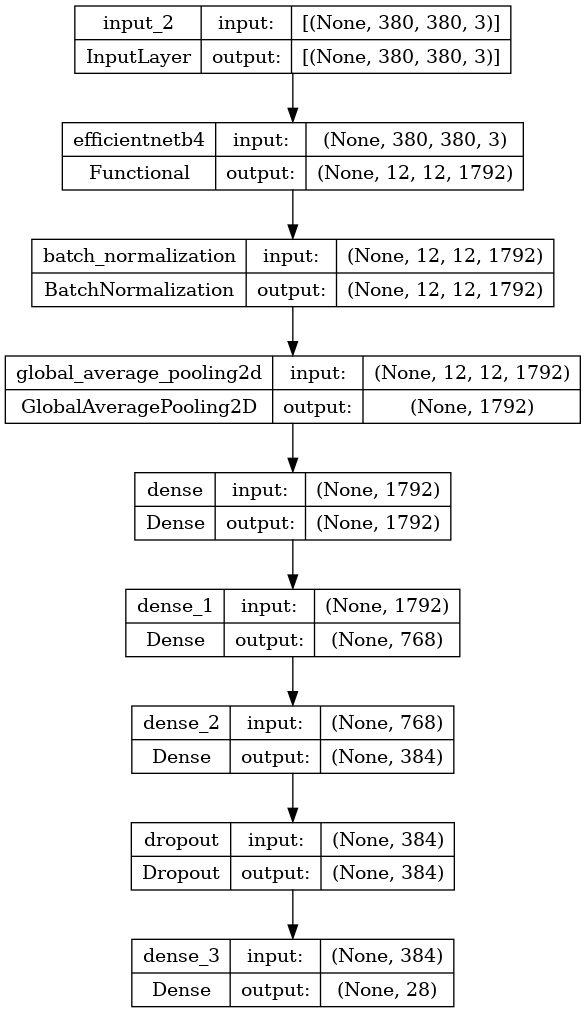

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Model Training

In this code  the machine learning model is trained using the specified number of epochs. The training and validation data generators are used, and class weights may be applied.

#### Training Description

The code snippet trains a machine learning model with the following parameters:

- `train_gen`: The training data generator, typically containing training data and labels.
- `epochs`: The number of training epochs to run.
- `val_gen`: The validation data generator, used to evaluate the model's performance.

#### Model Training

The `model.fit` method is called to start the training process. During training, the model learns from the training data and evaluates its performance on the validation data.

- The training data generator (`train_gen`) is used to feed training data to the model.
- Training runs for the specified number of epochs (`epochs`).
- The validation data generator (`val_gen`) is used to evaluate the model's performance on the validation set.
- If class weights are provided, they are used to balance the impact of different classes during training.


In [30]:
epochs=10
history = model.fit(x=train_gen, epochs=epochs, validation_data=val_gen, validation_steps=None)


Epoch 1/10
235/235 [==============================] - 296s 1s/step - loss: 0.6469 - accuracy: 0.1437 - auc: 0.5934 - auc_roc: 0.5934 - auc_pr: 0.0702 - precision: 0.1253 - recall: 0.0719 - f1_score: 0.0943 - hamming_loss: 0.0648 - map: 0.2820 - val_loss: 0.4883 - val_accuracy: 0.3148 - val_auc: 0.8332 - val_auc_roc: 0.8332 - val_auc_pr: 0.2844 - val_precision: 0.6804 - val_recall: 0.0543 - val_f1_score: 0.0905 - val_hamming_loss: 0.0452 - val_map: 0.4780
Epoch 2/10
235/235 [==============================] - 197s 837ms/step - loss: 0.4433 - accuracy: 0.2625 - auc: 0.7395 - auc_roc: 0.7395 - auc_pr: 0.1641 - precision: 0.4962 - recall: 0.1172 - f1_score: 0.1658 - hamming_loss: 0.0454 - map: 0.4251 - val_loss: 0.3701 - val_accuracy: 0.3715 - val_auc: 0.8857 - val_auc_roc: 0.8857 - val_auc_pr: 0.4256 - val_precision: 0.8045 - val_recall: 0.1184 - val_f1_score: 0.1774 - val_hamming_loss: 0.0423 - val_map: 0.5666
Epoch 3/10
235/235 [==============================] - 197s 838ms/step - loss: 0

### Fine-Tuning and Model Compilation

In this code the machine learning model undergoes fine-tuning, where previously frozen layers are allowed to be trainable again. Subsequently, the model is recompiled with specific parameters.

#### Fine-Tuning Description

The code snippet performs fine-tuning with the following steps:

- Within the same `tf.distribute.MirroredStrategy` scope, the previously frozen layers of the base model are set to be trainable (`base_model.trainable = True`).
- This step allows the fine-tuning of certain layers while keeping the knowledge learned from pre-training.

#### Model Compilation

After enabling fine-tuning, the model is recompiled with the following parameters:

- Optimizer: The Adam optimizer with a lower learning rate (`0.00001`) is used for fine-tuning.
- Loss: Binary cross-entropy loss is employed for multi-label classification.
- Metrics: The custom metrics specified earlier, including accuracy, AUC, precision, recall, F1 score, Hamming loss, and mean average precision (mAP), are used for model evaluation.

The model is now ready for continued training with fine-tuning, allowing it to adapt to specific tasks while leveraging pre-trained knowledge.



In [31]:

with strategy.scope():
    base_model.trainable = True
    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss="binary_crossentropy",
        metrics=metrics
    )

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 1792)     7168      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1792)              3213056   
                                                                 
 dense_1 (Dense)             (None, 768)               1377

In [33]:
epochs =20
patience= 8 
stop_patience =2 
threshold=.65 
factor=0.1 
dwell=True 
ask_epoch=100 
batches=train_steps
csv_path=os.path.join(working_dir,'my_csv')
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch, csv_path=csv_path )]

### Custom Colorful Text Printer

In this code a custom text printer function called `print_in_color` is defined. This function enables the printing of text messages in a user-specified foreground color on a custom background color. Here's an explanation of the code:

#### Custom Text Printer Function

- The `print_in_color` function is designed to display text in a customized color scheme.

- It accepts three parameters:

  - `txt_msg`: The text message to be printed.
  - `fore_tupple`: A tuple representing the RGB values of the foreground color.
  - `back_tupple`: A tuple representing the RGB values of the background color.

- Within the function, an ANSI escape code is constructed to specify the desired text and background colors using the RGB values provided in the tuples.

- The `print` function is used to display the `txt_msg` with the specified colors.

- After printing, a reset code (`'\33[0m'`) is included to return the print color to the default black.

This `print_in_color` function serves as a helpful tool for enhancing the visual appeal of text in code output or command line interfaces by incorporating custom colors.



In [34]:
import time
import datetime
from datetime import datetime
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) 
    return

### Fine-Tuning Model

In this code the machine learning model undergoes a fine-tuning process with a specified number of epochs, callbacks, class weights, and validation data.

#### Fine-Tuning Model

The code snippet fine-tunes the model with the following configurations:

- `train_gen`: The training data generator, typically containing training data and labels.
- `epochs`: The number of fine-tuning epochs.
- `verbose`: The verbosity level is set to 0, which means no training progress details are displayed during training.
- `callbacks`: The custom callbacks, such as learning rate adjustments, are applied during fine-tuning.
- `validation_data`: The validation data generator (`val_gen`) is used to evaluate the model's performance.
- `validation_steps`: The number of steps to evaluate the validation data. If set to `None`, the entire validation dataset is used.
- `shuffle`: Training data shuffling is disabled (set to `False`) to maintain data order.
- `initial_epoch`: The initial training epoch is set to 0.

Fine-tuning allows the model to adapt to specific tasks and further optimize its performance.


In [35]:
history_fine = model.fit(x=train_gen, epochs=epochs, verbose=0, callbacks=callbacks,
                    validation_data=val_gen, validation_steps=None, shuffle=False, initial_epoch=0)

 initializing callback starting training with base_model trainable

   Epoch        Loss      Accuracy      Auc       Auc_roc      Auc_pr     Precision      Recall     F1_score   Hamming_loss     Map         V_loss          V_acc          V_auc    Val_auc_roc   Val_auc_pr    Val_precision    Val_recall  Val_f1_score  Val_hamming_loss   Val_map          LR            Next LR         Monitor         % Improv       Duration  

 1 /200    0.153       57.025      92.931      92.931       58.119       0.789       0.378        0.468        0.033        0.726           0.143          61.242      94.588       94.588          69.550         0.820       0.423          0.498          0.031        0.762       0.00001000       0.00001000     val_accuracy       0.000         499.496   

 2 /200    0.145       60.384      93.978      93.978       63.411       0.803       0.435        0.526        0.030        0.755           0.136          65.418      95.654       95.654          73.753         0.879 

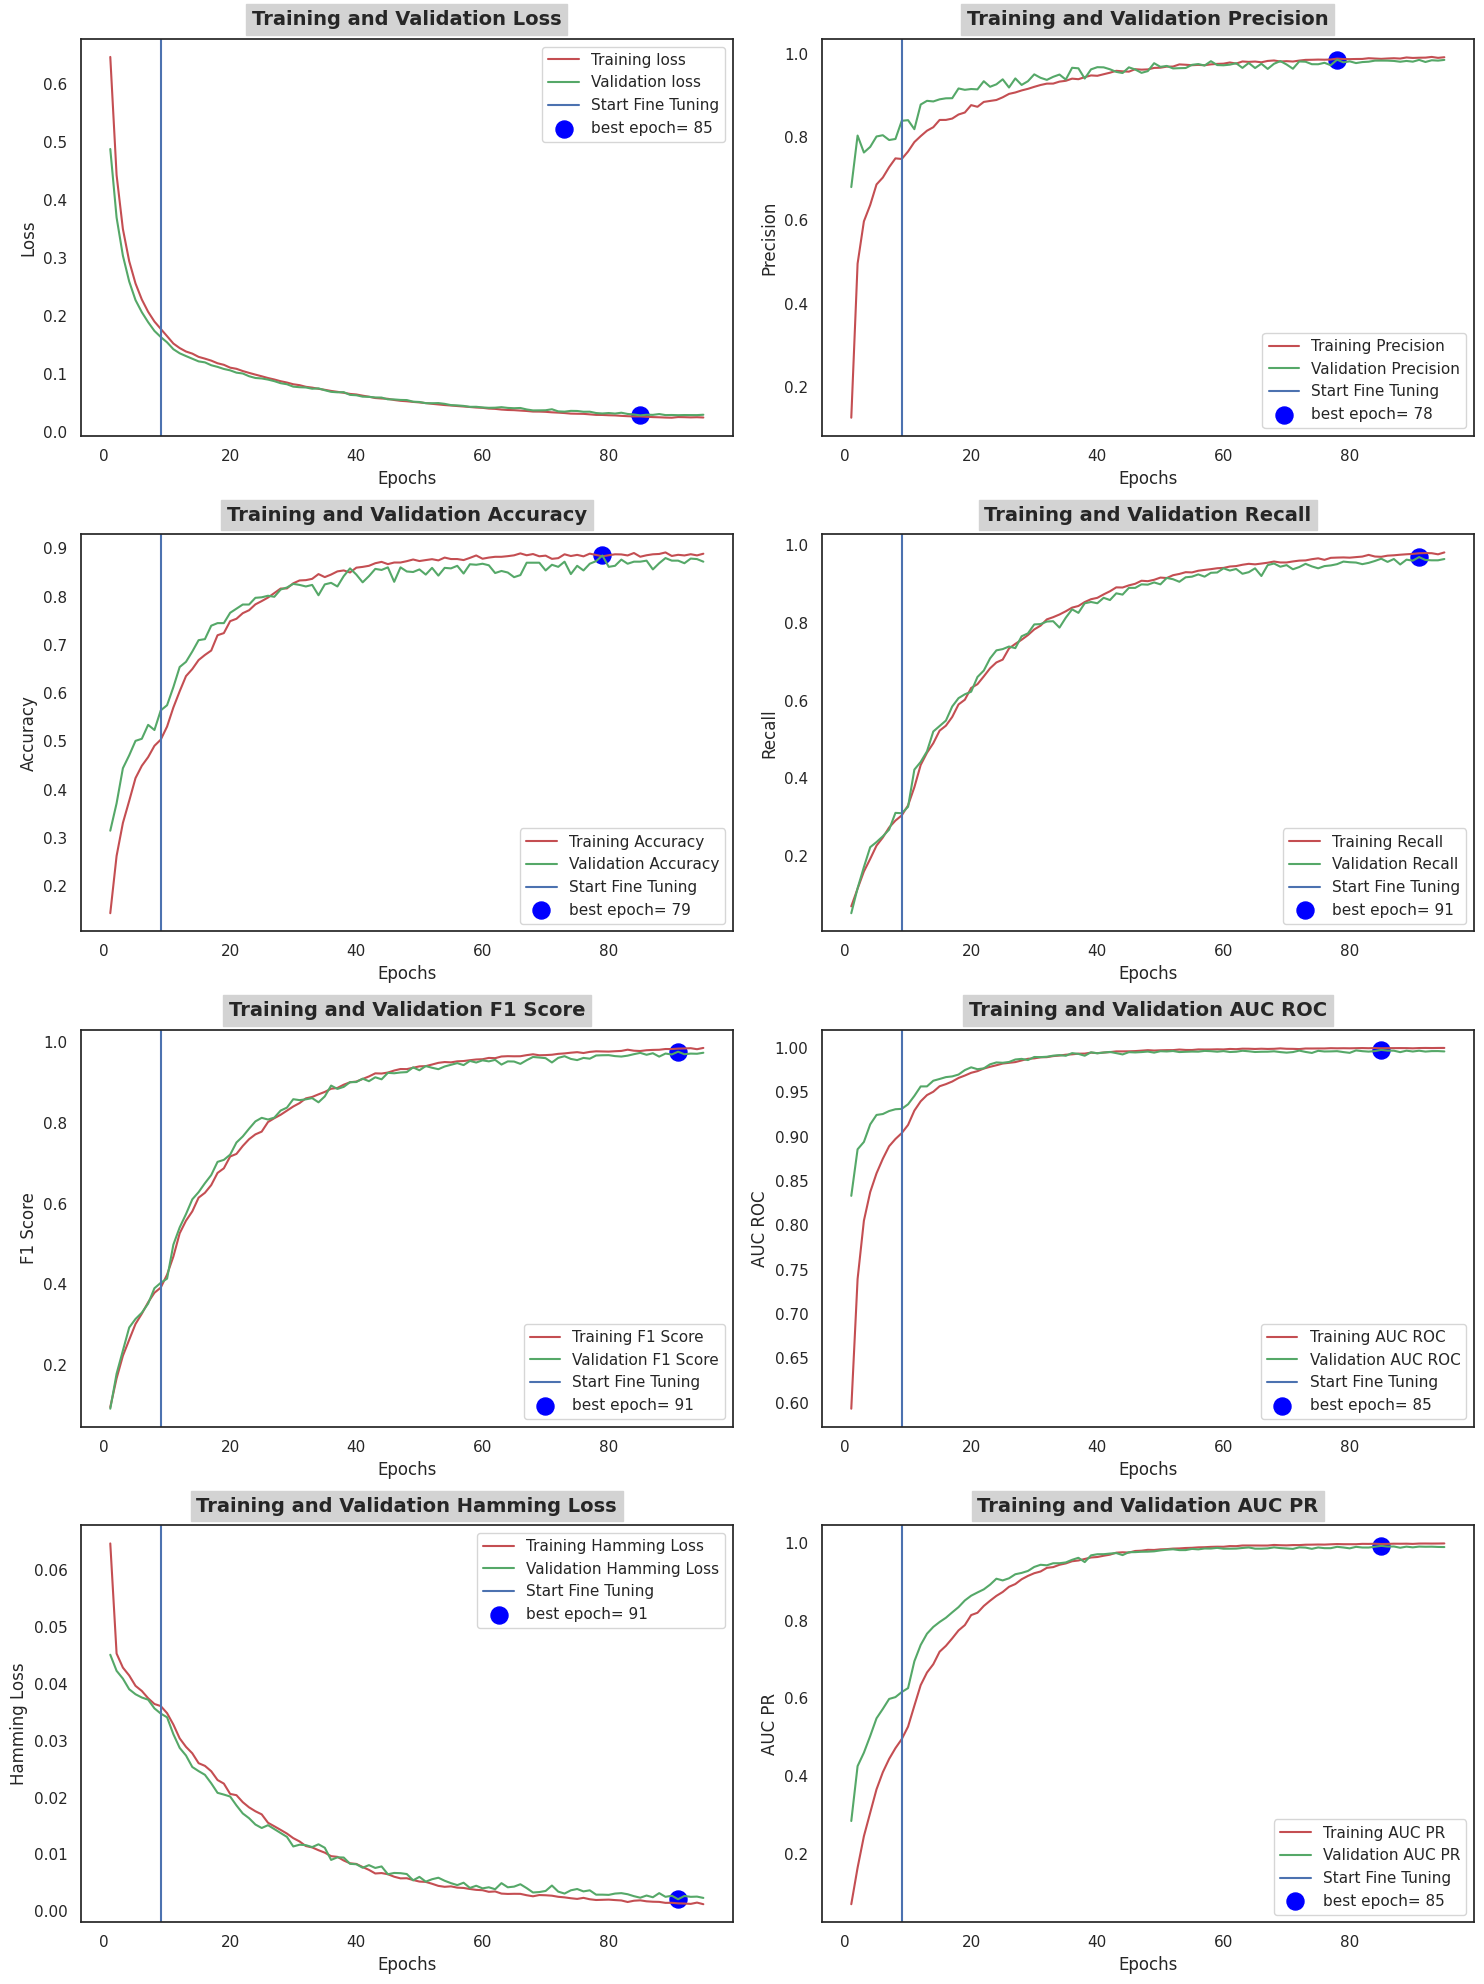

In [36]:
tr_plot(history_fine ,0,history)

In [37]:
print(dir(history)) 

print(history.model)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chief_worker_only', '_implements_predict_batch_hooks', '_implements_test_batch_hooks', '_implements_train_batch_hooks', '_keras_api_names', '_keras_api_names_v1', '_supports_tf_logs', 'epoch', 'history', 'model', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_predict_batch_begin', 'on_predict_batch_end', 'on_predict_begin', 'on_predict_end', 'on_test_batch_begin', 'on_test_batch_end', 'on_test_begin', 'on_test_end', 'on_train_batch_begin', 'on_train_batch_end', 'on_train_begin', 'on_train_end', 'params', 'set_model', 'set_params', 'validation_data']


In [38]:
y_pred_probs = model.predict(val_gen)

30/30 [==============================] - 30s 715ms/step


In [39]:
model_name='EfficientNetB4'

In [40]:

subject='Rfid'

### ROC and Precision-Recall Curves

In this code  Receiver Operating Characteristic (ROC) and Precision-Recall (PR) curves are generated for each class in a classification task.

#### ROC and Precision-Recall Curves

The code snippet calculates and plots ROC and PR curves for each class using the following steps:

- Calculate ROC and PR curves for each class:
  - The code iterates over each class, calculating the False Positive Rate (FPR) and True Positive Rate (TPR) for ROC curves and precision and recall for PR curves.
  - The area under the ROC curve (AUC) is calculated for each class and displayed in the legend.

- Plot ROC Curves:
  - The ROC curves for each class are plotted with distinct colors, and their AUC values are shown in the legend.
  - A diagonal dashed line representing the baseline (random classification) is also plotted.

- Plot Precision-Recall Curves:
  - The PR curves for each class are plotted with distinct colors.

Both ROC and PR curves provide insights into the model's classification performance for multiple classes.


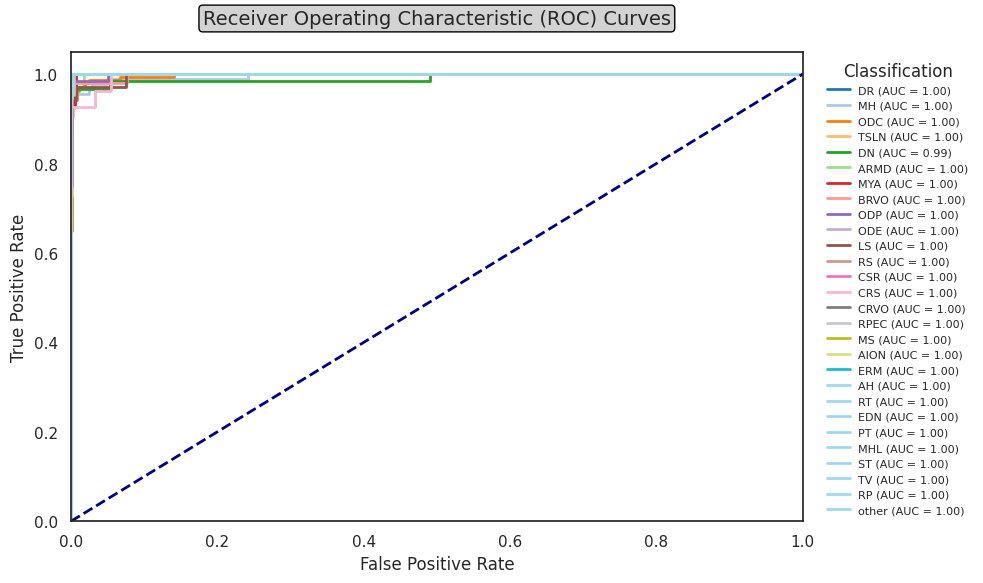

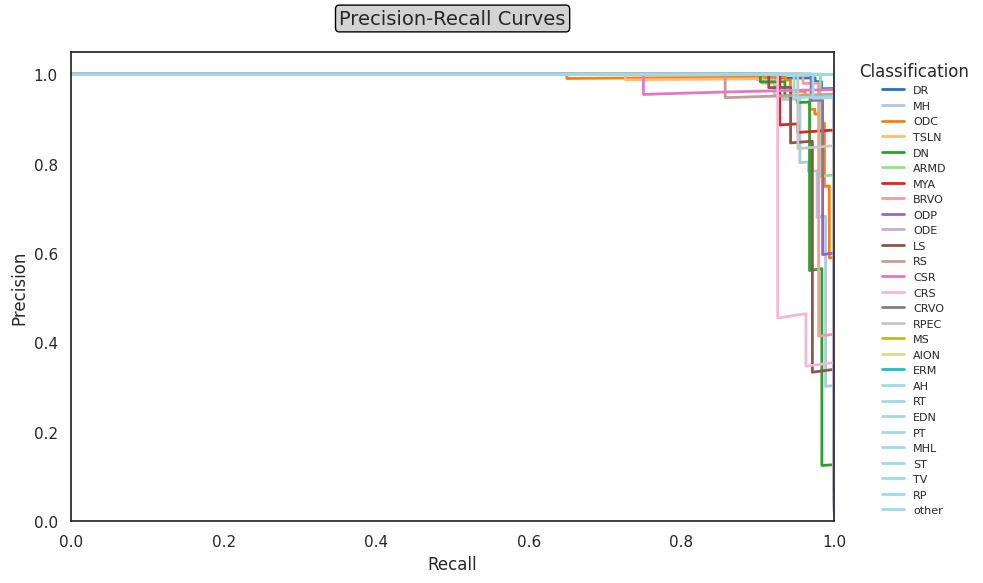

In [41]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


n_classes = len(labels)

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(val_gen.labels[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=plt.cm.tab20(i), lw=2, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=14, pad=20, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(1.02, 1), bbox_transform=ax.transAxes, prop={'size': 8}, frameon=False)
plt.gca().set_facecolor('white')  
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))


for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(val_gen.labels[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, color=plt.cm.tab20(i), lw=2, label=f'{labels[i]}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontsize=14, pad=20, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(1.02, 1), bbox_transform=ax.transAxes, prop={'size': 8}, frameon=False)
plt.gca().set_facecolor('white')  
plt.tight_layout()
plt.show()


In [42]:
# Evaluate the model
evaluation = model.evaluate(test_gen,verbose=0)

In [43]:

for name, value in zip(model.metrics_names, evaluation):
    print(name, ': ', value)
print()

loss :  0.032937899231910706
accuracy :  0.8625393509864807
auc :  0.995579183101654
auc_roc :  0.995579183101654
auc_pr :  0.9876728057861328
precision :  0.9782426953315735
recall :  0.9550653696060181
f1_score :  0.9662541151046753
hamming_loss :  0.0030355274211615324
map :  0.9849774241447449



In [44]:
print_code=0
preds=model.predict(test_gen) 

30/30 [==============================] - 23s 741ms/step


### Histogram of Predicted Probabilities

In this code  histograms of predicted probabilities are created and displayed for each label in a classification task.

#### Histogram of Predicted Probabilities

The code snippet performs the following steps:

- Define the number of labels and the desired number of columns for subplots.
- Calculate the number of rows needed for subplots based on the number of labels and the number of columns.
- Create a figure with subplots to display the histograms.

- Loop over each label:
  - For each label, create a histogram of predicted probabilities.
  - Set the number of bins in the histogram to 20 for visualization.
  - Adjust the alpha (transparency) and color of the histogram bars.
  - Label the x-axis with "Predicted Probability" and the y-axis with "Frequency."
  - Set the title of each subplot to indicate the label being visualized.

- Ensure that the layout is adjusted to prevent subplot overlap.

The resulting visualizations provide insights into the distribution of predicted probabilities for each label, which can be helpful in understanding the model's predictions.



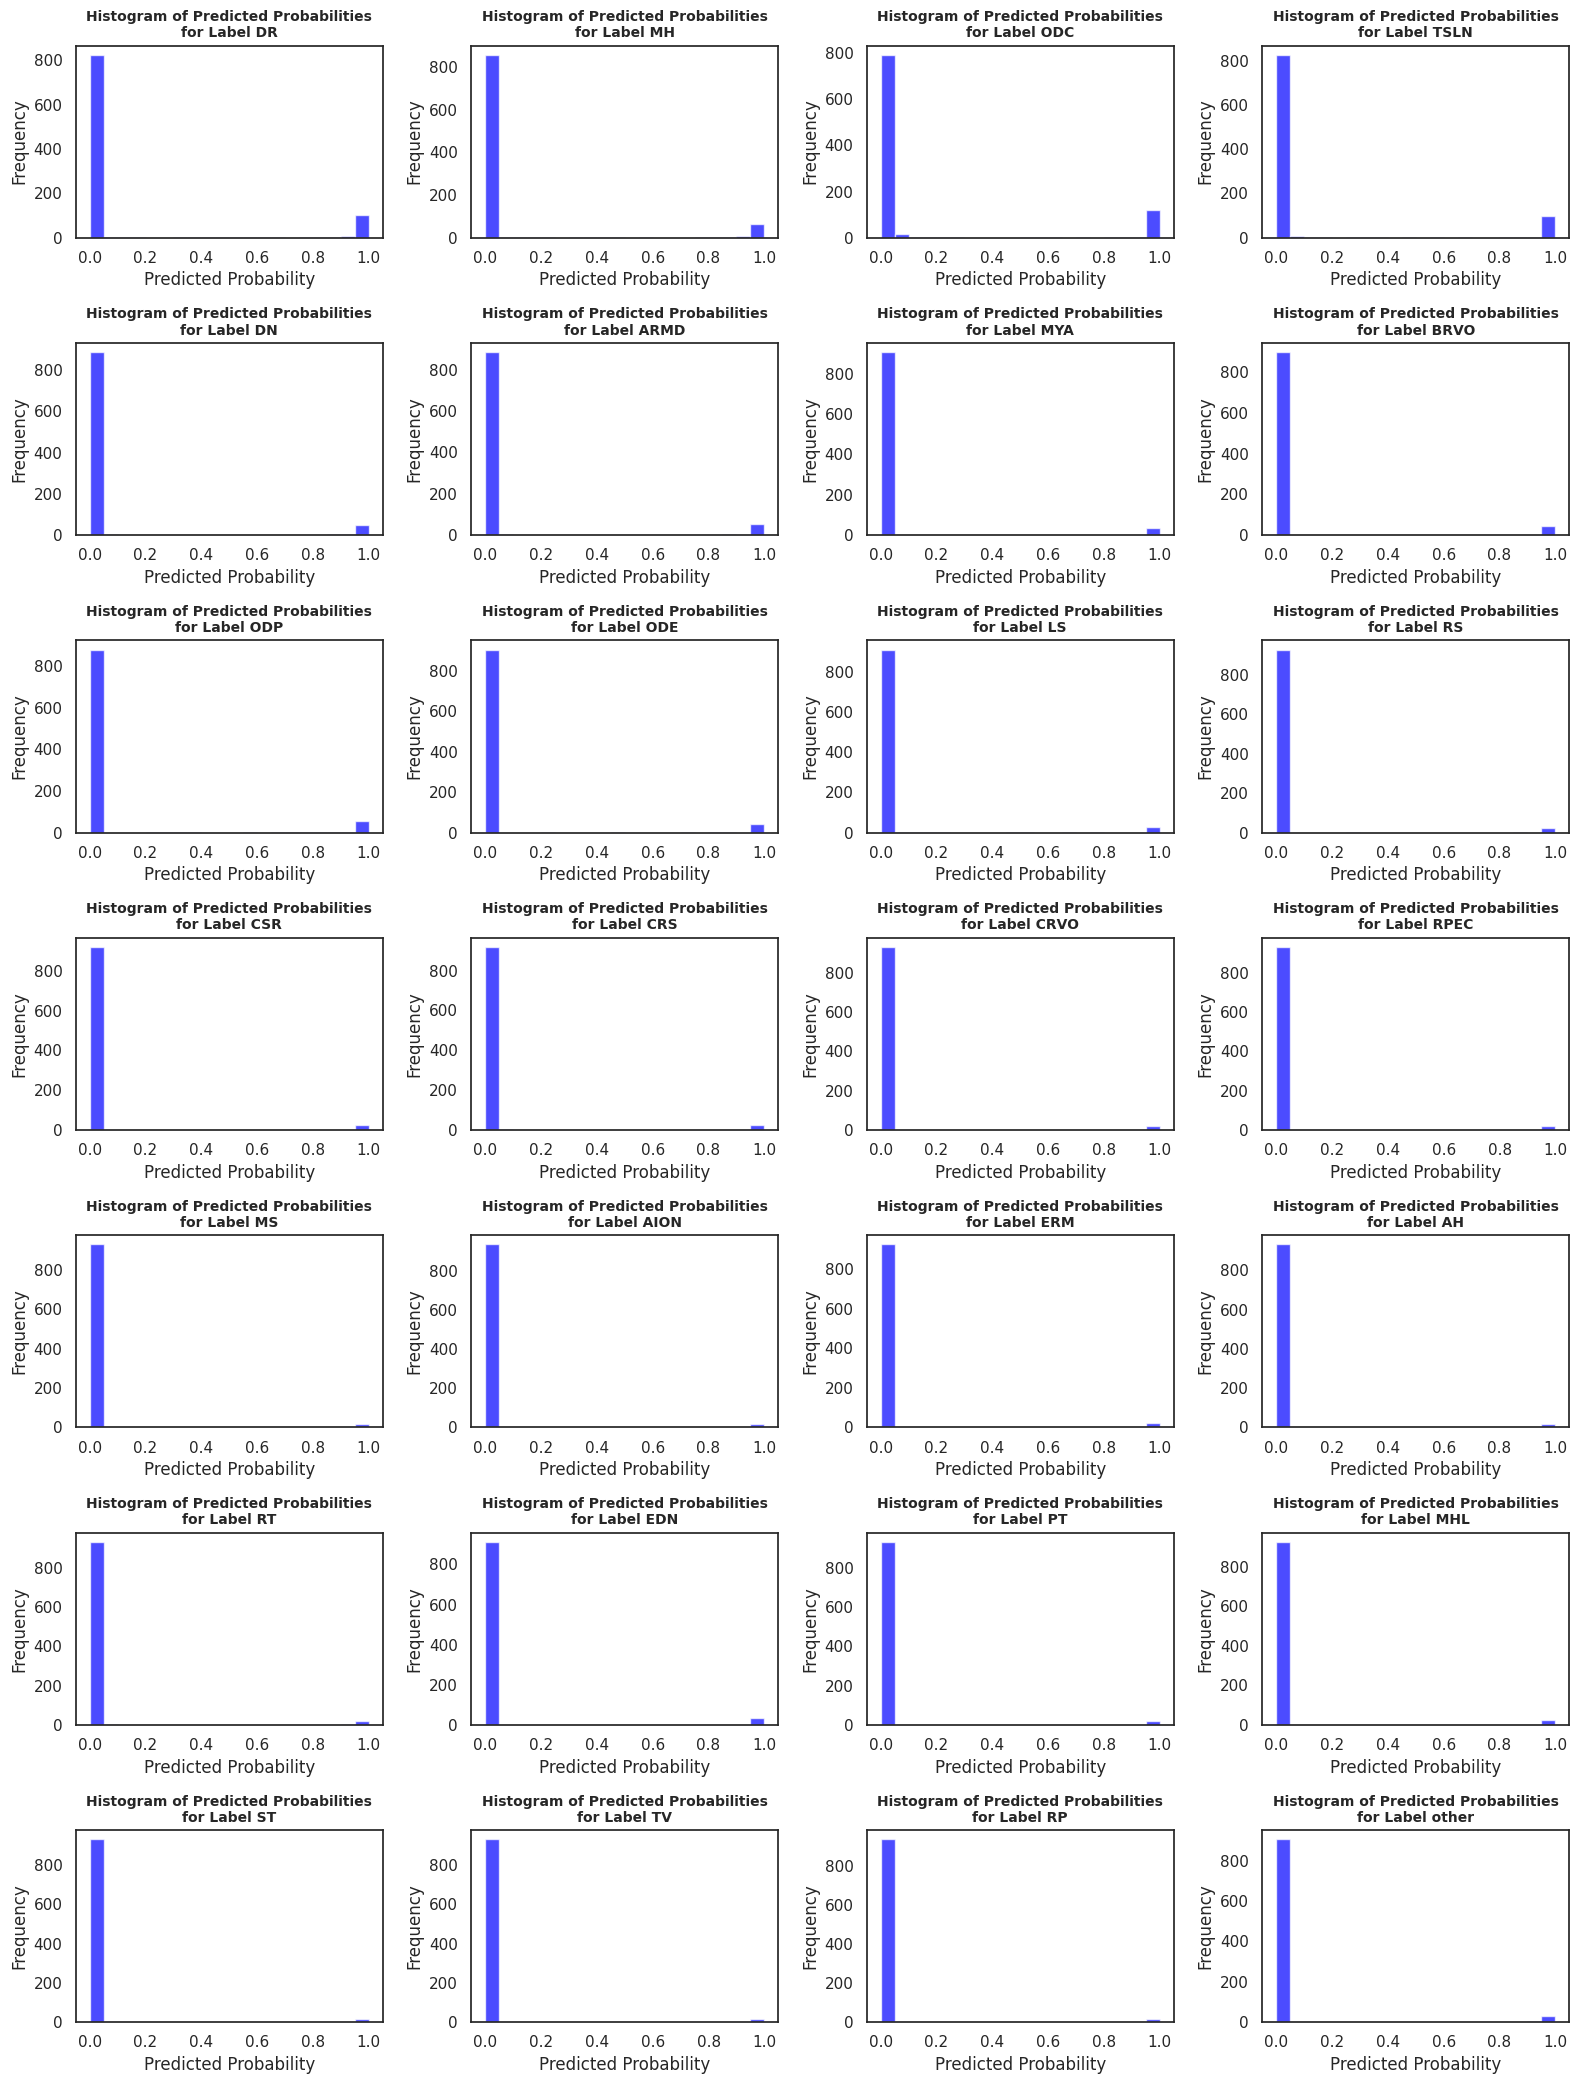

In [45]:


num_labels = labels  
num_columns = 4  
num_rows = (len(num_labels) + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 3*num_rows))  

for label_index in range(len(num_labels)):
    row = label_index // num_columns
    col = label_index % num_columns
    label_preds = preds[:, label_index]  
    
    ax = axes[row, col]
    ax.hist(label_preds, bins=20, alpha=0.7, color='blue')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of Predicted Probabilities\nfor Label {num_labels[label_index]}', fontsize=10,fontweight='bold')  


plt.tight_layout()
plt.show()


In [46]:
a=preds

There were 61 errors in 953 test cases Model accuracy=  93.60 %



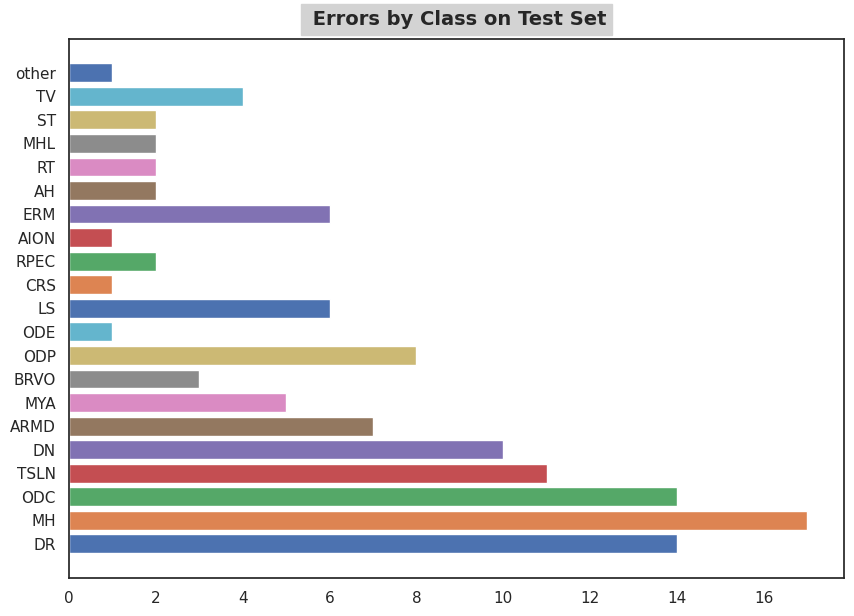

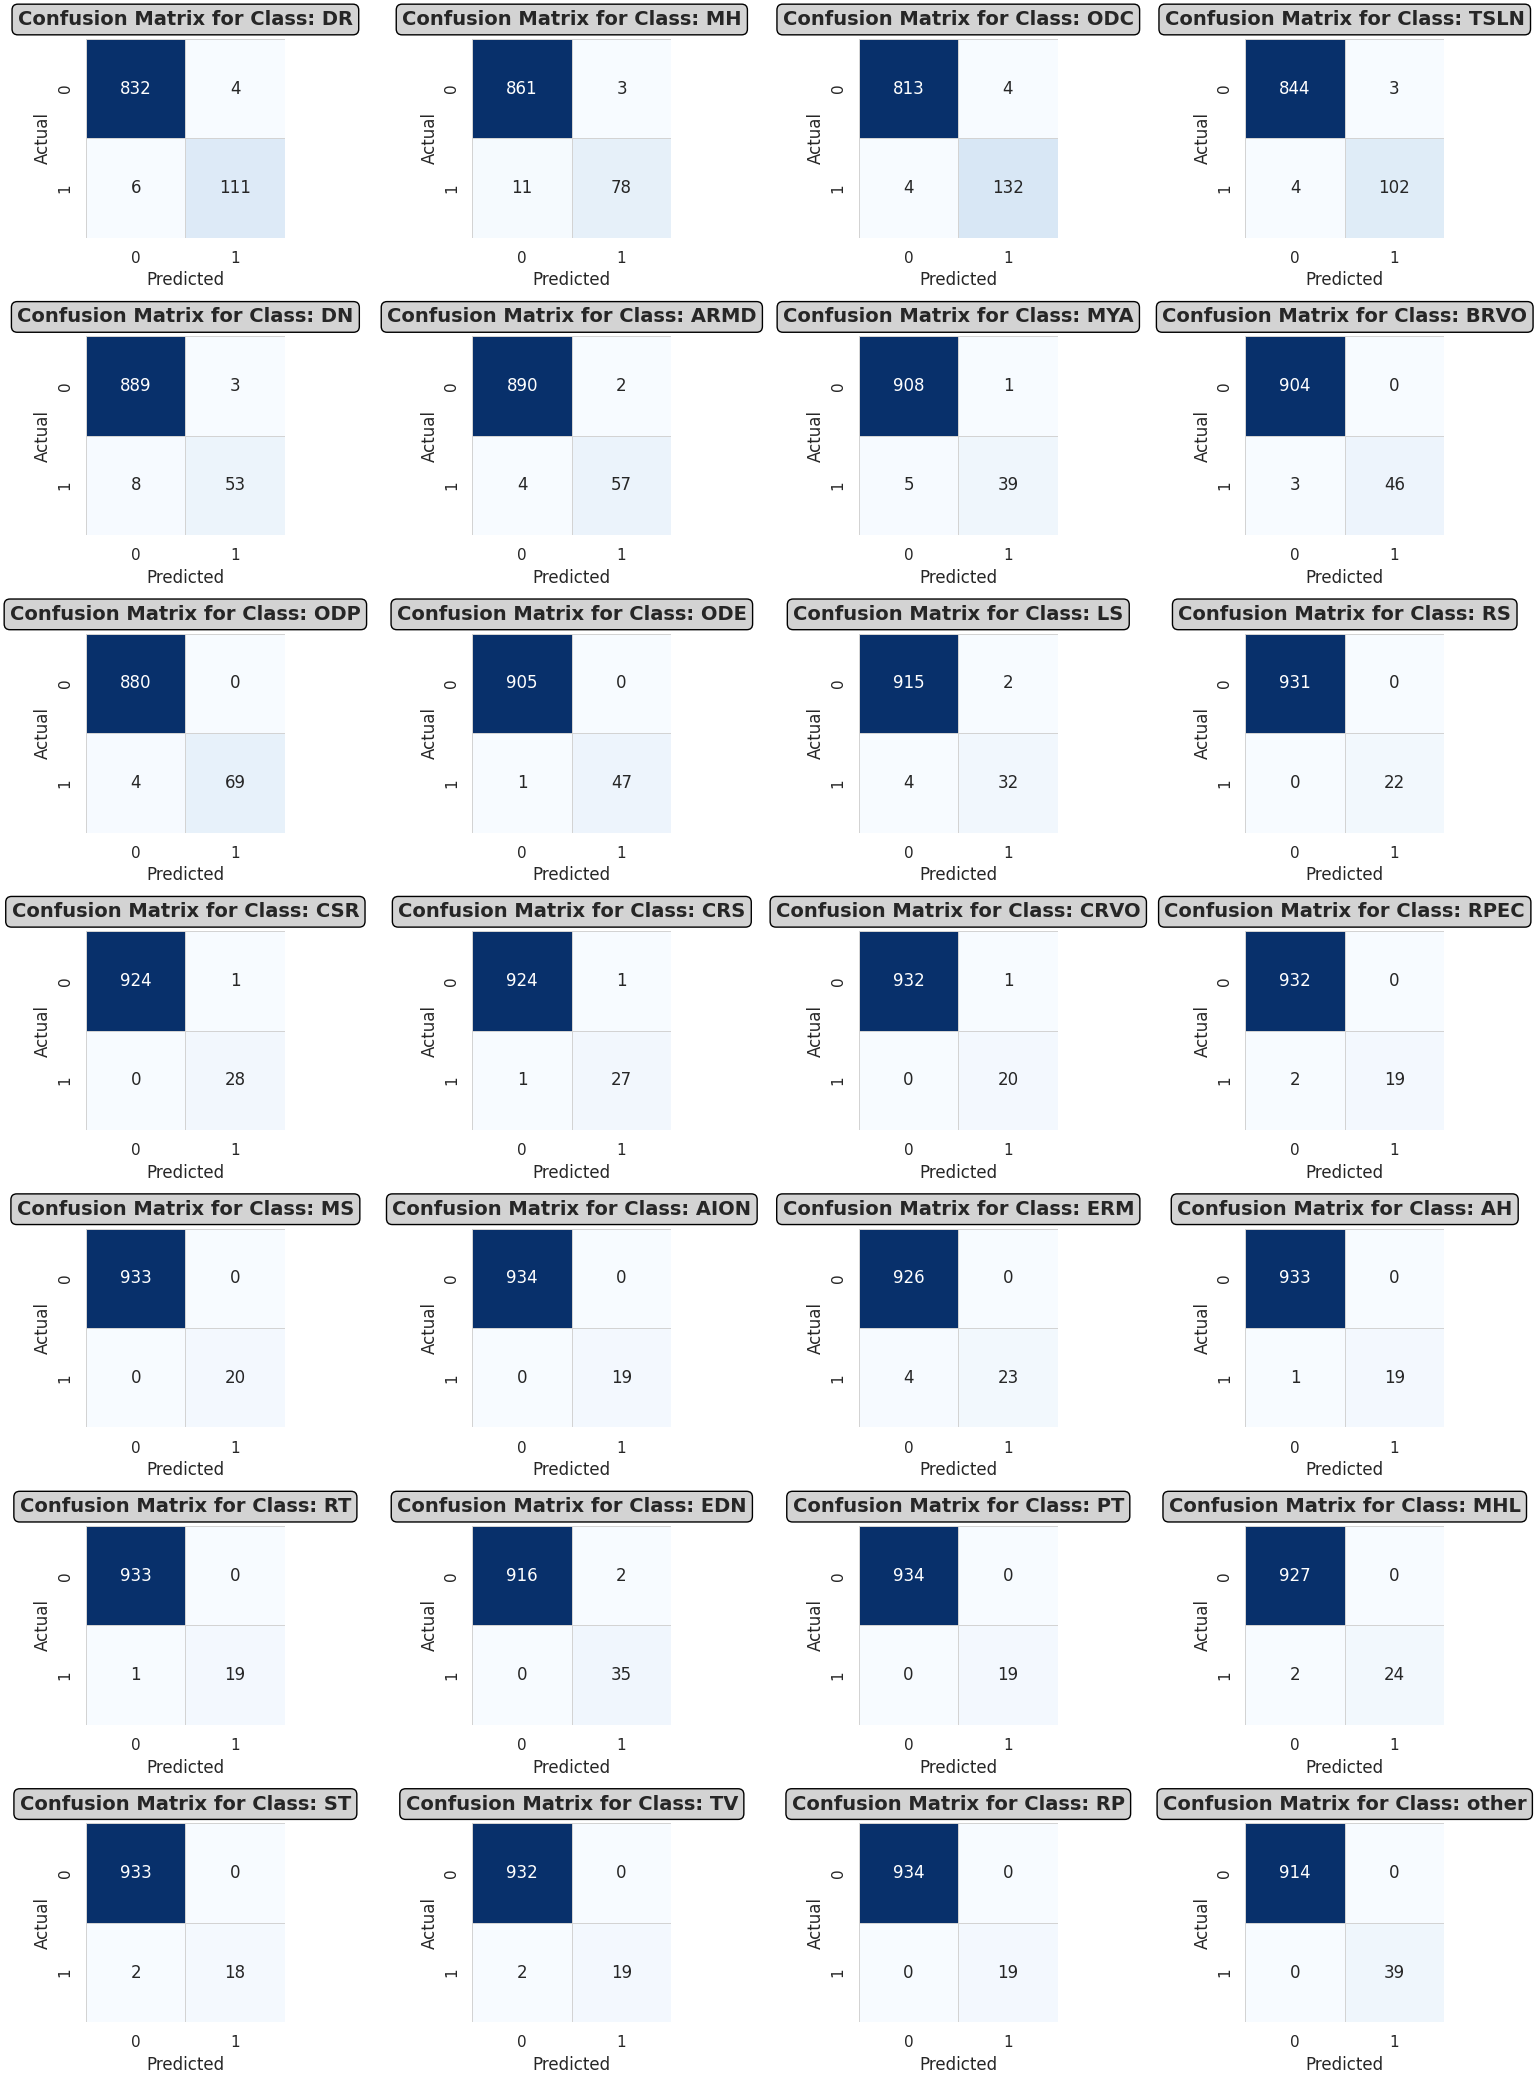

Classification Report:
----------------------
               precision    recall  f1-score   support

          DR     0.9652    0.9487    0.9569       117
          MH     0.9630    0.8764    0.9176        89
         ODC     0.9706    0.9706    0.9706       136
        TSLN     0.9714    0.9623    0.9668       106
          DN     0.9464    0.8689    0.9060        61
        ARMD     0.9661    0.9344    0.9500        61
         MYA     0.9750    0.8864    0.9286        44
        BRVO     1.0000    0.9388    0.9684        49
         ODP     1.0000    0.9452    0.9718        73
         ODE     1.0000    0.9792    0.9895        48
          LS     0.9412    0.8889    0.9143        36
          RS     1.0000    1.0000    1.0000        22
         CSR     0.9655    1.0000    0.9825        28
         CRS     0.9643    0.9643    0.9643        28
        CRVO     0.9524    1.0000    0.9756        20
        RPEC     1.0000    0.9048    0.9500        21
          MS     1.0000    1.0000 

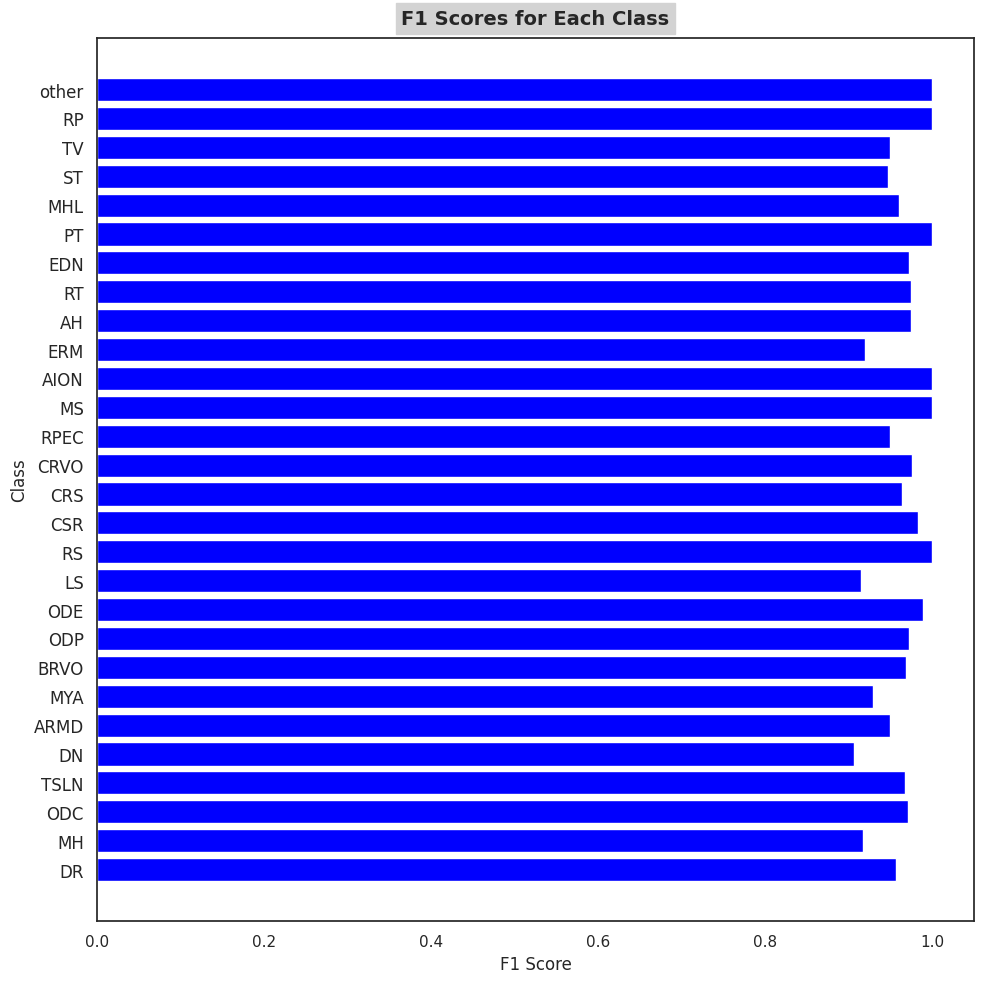

In [47]:
acc=print_info( test_gen, preds, print_code ) 

In [48]:
img_size=(380,380)

In [49]:
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, 1,0,  train_gen)

model was saved as /kaggle/working/EfficientNetB4-Rfid-0.93.h5

class csv file was saved as /kaggle/working/class_dict.csv



### Zip Files in a Directory

In this code files in a specified directory are zipped into a compressed archive file.

#### Zip Files in a Directory

The code snippet performs the following steps:

- Defines the directory path that contains the files you want to zip. You can replace `/kaggle/working/` with the directory path you wish to use.

- Defines the desired output zip file path and name. You can replace `/kaggle/working/EfficientNetb4weight.zip` with the desired output zip file location.

- Lists all files in the specified directory using a list comprehension.

- Creates a new zip file using the `zipfile.ZipFile` class, specifying the output zip file name and the compression method (ZIP_DEFLATED).

- Iterates over the list of files, adds each file to the zip archive with its original filename.

- Prints a confirmation message indicating that the zip file has been created successfully.

This code is useful for compressing files in a directory into a single zip archive, making it easier to store or share multiple files.


In [50]:
import os
import zipfile

directory = '/kaggle/working/'  
output_zip_filename = '/kaggle/working/EfficientNetb4.zip'  


files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

with zipfile.ZipFile(output_zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in files:
        file_path = os.path.join(directory, file)
        zipf.write(file_path, os.path.basename(file_path))

print(f'Zip file "{output_zip_filename}" created successfully.')


Zip file "/kaggle/working/EfficientNetb4.zip" created successfully.


### Multilabel Classification Report

In this code  a custom function named `multilabel_classification_report` is defined to generate a classification report for multilabel classification tasks.

#### `multilabel_classification_report` Function

- The code defines a function named `multilabel_classification_report` that takes two input parameters: `y_true` and `y_pred`. 
  - `y_true`: The true labels or ground truth.
  - `y_pred`: The predicted labels or model predictions.

- Inside the function, a classification report is generated using the `classification_report` function from scikit-learn. The report includes metrics such as precision, recall, F1-score, and support for each label in the multilabel classification task.

- The `target_names` parameter is set to `labels`, which likely contains the names of the classes involved in the classification task.

- The `zero_division` parameter is set to 1 to handle cases where division by zero may occur.

- The generated classification report is returned as the output of the function.



In [51]:
def multilabel_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=labels,zero_division=1)
    return report


### Matthews Correlation Coefficient Thresholding for Multilabel Classification

In this code the implementation of thresholding for the Matthews Correlation Coefficient (MCC) to determine the optimal threshold values for multilabel classification.

#### Method Overview

- The code begins by assuming that you already have model predictions stored in the variable `out` and ground truth labels in `y_test`.

- It sets up an array of thresholds, starting from 0.5 and incrementing by 0.01 up to 0.9.

- It initializes empty arrays `acc` and `accuracies` to store MCC values and the best threshold for each label, respectively.

- The code iterates through the labels (classes) in your multilabel classification task. For each label:
  - It computes the MCC for different thresholds and stores them in the `acc` array.
  - It finds the threshold that maximizes the MCC and appends it to the `best_threshold` array.

- After processing all labels, the code calculates the best thresholds for all labels and stores them in `best_threshold`.

- It computes predicted labels `y_pred` by applying the optimal thresholds to the model's predictions.

- Finally, it generates a multilabel classification report using the `multilabel_classification_report` function to evaluate the model's performance based on the best thresholds.

- The classification report is printed or used as needed for further analysis.



In [52]:
import numpy as np
from sklearn.metrics import matthews_corrcoef


out=a
threshold = np.arange(0.5, 0.9, 0.01)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
y_true = test_gen.labels
for i in range(out.shape[1]):
    y_prob = np.array(out[:, i])
    for j in threshold:
        y_pred = [1 if prob >= j else 0 for prob in y_prob]
        acc.append(matthews_corrcoef(test_gen.labels[:, i], y_pred))
    acc = np.array(acc)
    index = np.where(acc == acc.max())
    accuracies.append(acc.max())
    best_threshold[i] = threshold[index[0][0]]
    acc = []

print("best thresholds: " + str(best_threshold))

y_pred = np.array([[1 if out[i, j] >= best_threshold[j] else 0 for j in range(out.shape[1])] for i in range(len(out))])
report = multilabel_classification_report(y_true, y_pred)


print(report)

best thresholds: [0.54 0.59 0.56 0.5  0.5  0.86 0.75 0.5  0.5  0.5  0.5  0.5  0.6  0.5
 0.75 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
              precision    recall  f1-score   support

          DR       0.97      0.95      0.96       117
          MH       0.99      0.88      0.93        89
         ODC       0.99      0.97      0.98       136
        TSLN       0.97      0.96      0.97       106
          DN       0.95      0.87      0.91        61
        ARMD       1.00      0.93      0.97        61
         MYA       1.00      0.89      0.94        44
        BRVO       1.00      0.94      0.97        49
         ODP       1.00      0.95      0.97        73
         ODE       1.00      0.98      0.99        48
          LS       0.94      0.89      0.91        36
          RS       1.00      1.00      1.00        22
         CSR       1.00      1.00      1.00        28
         CRS       0.96      0.96      0.96        28
        CRVO       1.00      1

## F1 Score Analysis for Multilabel Classification

### Overview

This code performs an analysis of F1 scores for multilabel classification. It calculates F1 scores for individual labels and the average weighted F1 score.

### Code Explanation

1. Import the necessary libraries, including `f1_score` from `sklearn.metrics` and `seaborn` for visualization.

2. Set the plotting style to 'white' using `sns.set(style='white')`.

3. Calculate F1 scores for each label in the multilabel classification task. The code iterates through the labels, using the `f1_score` function to compute F1 scores for each label.

4. Compute the average weighted F1 score using the `f1_score` function with `average='weighted'`.

5. Create a list of class labels, which is stored in the `classes` variable.

6. Adjust the figure size and font size for y-axis tick labels for improved visualization.

7. Generate a horizontal bar plot of F1 scores for each class using `plt.barh`. The x-axis represents the F1 score, and the y-axis represents class labels.

8. Set the plot's title, axis labels, and other visual elements to create a clear and informative visualization.

This code provides an analysis of F1 scores for each class in a multilabel classification task, enabling the assessment of model performance on individual classes and overall class imbalance.

The analysis helps identify classes where the model performs well and those that may require further improvement.


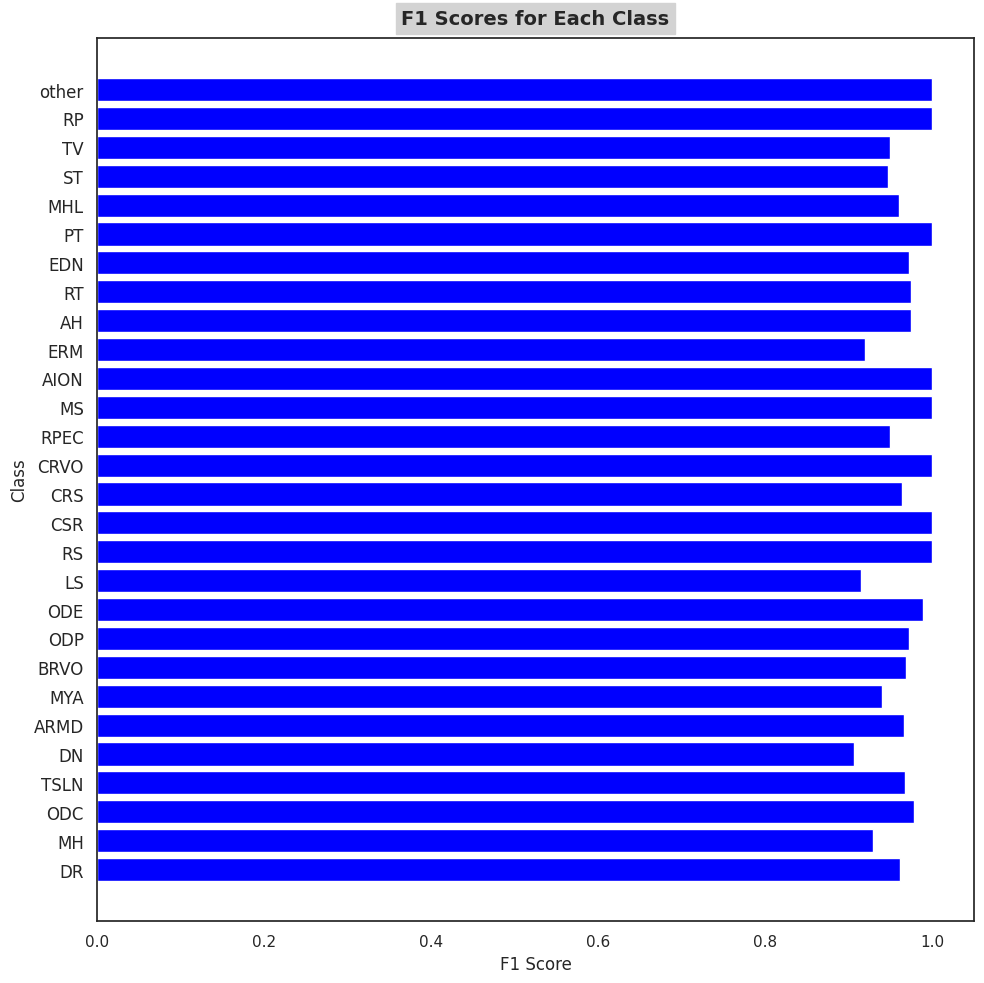

In [53]:
from sklearn.metrics import f1_score
sns.set(style='white')

f1_scores = [f1_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]


average_weighted_f1 = f1_score(y_true, y_pred, average='weighted')


classes = labels


plt.figure(figsize=(10, 10))
plt.rcParams['ytick.labelsize'] = 12  
bar_positions = range(len(classes))
plt.barh(bar_positions, f1_scores, color='blue')
plt.xlabel("F1 Score")
plt.ylabel("Class")
plt.title("F1 Scores for Each Class", fontsize=14, fontweight='bold', pad=10, backgroundcolor='lightgray')
plt.yticks(bar_positions, classes)  
plt.tight_layout()
plt.show()
